<h1><center>Opmatch</center>
</h1>

<center>A lightweight package for optimal case-control matching.</center>

<h3 align="center">
    <a href="#-Introduction">Introduction</a> &bull;
    <a href="#-quick-tour">Quick Tour</a> &bull;
    <a href="#getting_started">Getting Started</a>
</h3>

## 📚 Introduction 
-------------------------------

Here, we provide a tool to perform matching of controls to cases (or untreated to treated subjects) for observational studies. 
This tool allows to easily perform optimal matching. In optimal matching the sum of all the pairwise case-control distances is minimized.
In the simplest case, there is a constant matching ratio, chosen by the researcher. But, the algorithm also allows for a variable ratio match, where the user selects a minimum and a maximum matching ratio as well as the total number of controls to match. 

## ⚡️ Getting Started
<a id='getting_started'></a>
-------------------------

```bash
pip install opmatch
```
or
```bash
conda install -c conda-forge opmatch
```

## 🚀 Quick Tour
<a id='-quick tour'></a>
----------------------------------

To obtain matches you can simply run:

```python
from opmatch.matcher import Matcher
case_control_dict = Matcher(
        df, matching_ratio, 
        min_mr, max_mr, n_controls, 
        metric, matching_type,
        case_col, var_cols,  ps_col,
        ).match()
```
>#### Parameters

* **matching_ratio** number of controls per case if matching ratio is constant

* **min_mr**: minimum number of controls per case
* **max_mr**: maximum number of controls per case
* **n_controls**: number of controls to match
* **metric**: PS or one of the metrics accepted by scipy.spatial.distances.cdist
* **matching_type**: constant or variable matching ratio
* **case_col**: boolean column where cases are 1s and controls 0s
* **var_cols**: columns containing relevatn patient variables
        if metric!=PS: var_cols used for matching
        if metric==PS but ps_col is not specified: var_cols used to compute PS using logistic regression
* **ps_col**: column containing the propensity score
* **case_col**: column name of case column, should contain 1s and 0s





### Generate Example Data

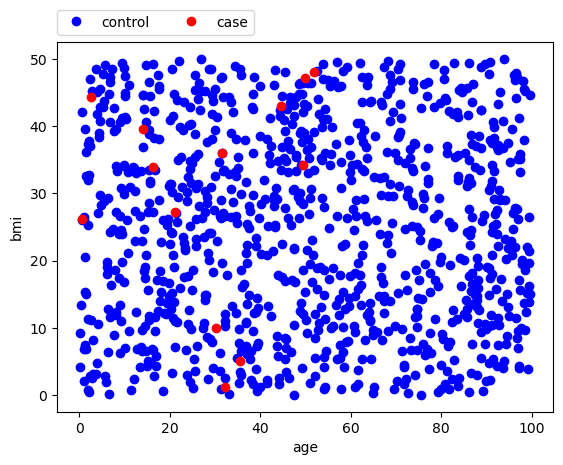

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_patients = 1000
age = np.random.uniform(0, 100, num_patients)
bmi = np.random.uniform(0, 50, num_patients)
case = np.random.binomial(1, .01, num_patients)
df = pd.DataFrame({'age':age, 'bmi':bmi, 'case':case})

plt.plot(df.age[df.case==0], df.bmi[df.case==0], 'bo', label='control')
plt.plot(df.age[df.case==1], df.bmi[df.case==1], 'ro', label='case')
plt.xlabel('age')
plt.ylabel('bmi')
plt.legend(loc=(0,1.02), ncol=2)

## Perform matching

In [3]:
from opmatch.matcher import Matcher
cc_dic_const = Matcher(df=df, matching_ratio=5, metric='mahalanobis', 
            matching_type='const', var_cols=['age','bmi']).match()

Number of cases: 13
Size of the control pool: 987
alpha=5, beta=5, M=987, m=65, n=13


TypeError: cdist_mahalanobis_double_wrap() takes at most 4 arguments (5 given)

In [82]:
cc_dic = Matcher(df=df, min_mr=1, max_mr=2, n_controls=14, metric='ps', 
            matching_type='variable', var_cols=['age','bmi']).match()
print(cc_dic)

Number of cases: 10
Size of the control pool: 990
alpha=1, beta=2, M=990, m=14, n=10
defaultdict(<class 'list'>, {32: [240, 223], 175: [247, 500], 237: [486, 705], 251: [733, 645], 309: [445, 529], 587: [449], 682: [264], 712: [423], 946: [78], 976: [289]})


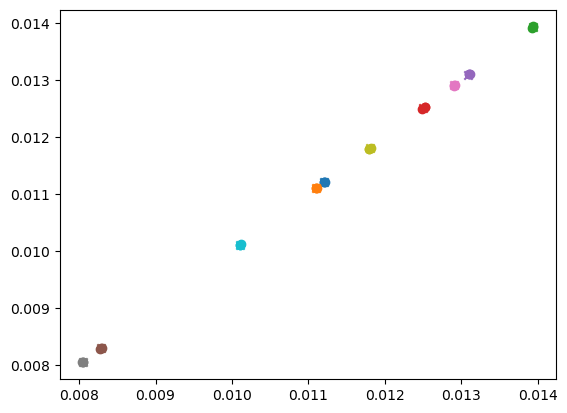

In [101]:
fig, ax = plt.subplots()
# get colorwheel
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matched = []
for color, (case, controls) in zip(colors, cc_dic.items()):
    matched.extend(controls)
    matched.append(case)
    ax.scatter(df.loc[case, 'ps'], df.loc[case, 'ps'], color = color, marker = 'x')
    ax.scatter(df.loc[controls, 'ps'], df.loc[controls, 'ps'], color = color, marker='o')
unmatched = [i for i in df.index if i not in matched]
#ax.scatter(df.loc[unmatched, 'ps'], df.loc[unmatched, 'ps'], color = 'k', marker='.', alpha=.2)

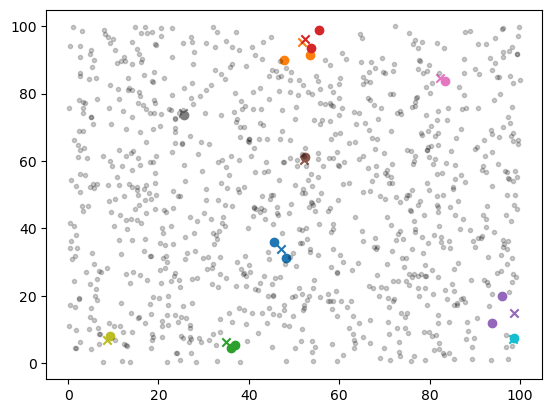

In [81]:
fig, ax = plt.subplots()
# get colorwheel
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matched = []
for color, (case, controls) in zip(colors, cc_dic.items()):
    matched.extend(controls)
    matched.append(case)
    ax.scatter(df.loc[case, 'age'], df.loc[case, 'bmi'], color = color, marker = 'x')
    ax.scatter(df.loc[controls, 'age'], df.loc[controls, 'bmi'], color = color, marker='o')
unmatched = [i for i in df.index if i not in matched]
ax.scatter(df.loc[unmatched, 'age'], df.loc[unmatched, 'bmi'], color = 'k', marker='.', alpha=.2)

In [ ]:
# distance matrix is n_controlsxn_cases

d:\Thesis\opmatch\opmatch\util\variable_ratio_match.py:75: UserWarning: var_cols not specified, use all df columns, except for case column, to match on.
  warnings.warn('var_cols not specified, use all df columns, except for case column, to match on.')


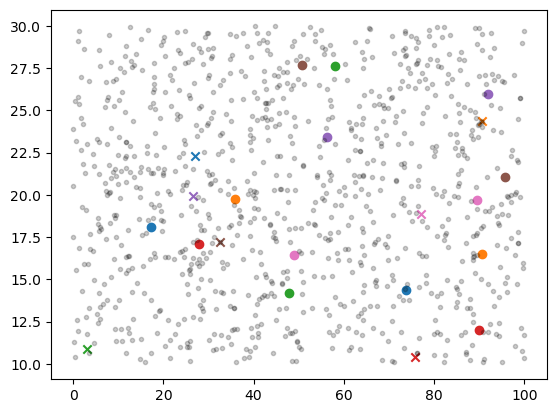

In [5]:
from opmatch import main
case_control_dic = main.match(df=df, matching_ratio=2, metric='Mahalanobis', 
                    matching_type='const')
fig, ax = plt.subplots()
# get colorwheel
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matched = []
for color, (case, controls) in zip(colors, case_control_dic.items()):
    matched.extend(controls)
    matched.append(case)
    ax.scatter(df.loc[case, 'age'], df.loc[case, 'bmi'], color = color, marker = 'x')
    ax.scatter(df.loc[controls, 'age'], df.loc[controls, 'bmi'], color = color, marker='o')
unmatched = [i for i in df.index if i not in matched]
ax.scatter(df.loc[unmatched, 'age'], df.loc[unmatched, 'bmi'], color = 'k', marker='.', alpha=.2)